## GLS map-making for I, Q, and U components with litebird_sim data using dedicated wrapper function

This example illustrates the GLS map-making for I, Q, and U components from `litebird_sim` data using dedicated wrapper function. `BrahMap` offers complete integration with `litebird_sim` eliminating the need to store the TODs and pointings to the disk.

In [ ]:
### If you are using Google Colab, uncomment the following line and execute this cell to install the required packages

# %pip install matplotlib healpy litebird_sim git+https://github.com/anand-avinash/BrahMap.git

In [1]:
import tempfile
import numpy as np
import matplotlib.pyplot as plt

import healpy as hp
import litebird_sim as lbs
import brahmap

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


### Producing the input maps, pointings and TOD using litebird_sim

In [2]:
### Mission parameters
telescope = "MFT"
channel = "M1-195"
detectors = [
    "001_002_030_00A_195_B",
    "001_002_029_45B_195_B",
    "001_002_015_15A_195_T",
    "001_002_047_00A_195_B",
]
start_time = 51
mission_time_days = 30
detector_sampling_freq = 1

### Simulation parameters
nside = 128
random_seed = 45
imo_version = "vPTEP"
imo = lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION)
dtype_float = np.float64
tmp_dir = tempfile.TemporaryDirectory()

In [3]:
### Initializing the simulation
sim = lbs.Simulation(
    random_seed=random_seed,
    base_path=tmp_dir.name,
    name="brahmap_example",
    start_time=start_time,
    duration_s=mission_time_days * 24 * 60 * 60.0,
    imo=imo,
)

In [4]:
### Instrument definition
sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
    )
)

In [5]:
### Detector list
detector_list = []
for n_det in detectors:
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
        imo=imo,
    )
    det.sampling_rate_hz = detector_sampling_freq
    detector_list.append(det)

In [6]:
### Scanning strategy
sim.set_scanning_strategy(
    imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/"
)

In [7]:
### Create observations
sim.create_observations(
    detectors=detector_list,
    num_of_obs_per_detector=3,
    n_blocks_det=1,
    n_blocks_time=1,
    split_list_over_processes=False,
    tod_dtype=dtype_float,
)

In [8]:
### Prepare pointings
sim.prepare_pointings()

In [9]:
### Compute pointings (optional)
sim.precompute_pointings(pointings_dtype=dtype_float)

In [10]:
### Channel info
ch_info = []
n_ch_info = lbs.FreqChannelInfo.from_imo(
    imo,
    f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
)
ch_info.append(n_ch_info)


### CMB map
mbs_params = lbs.MbsParameters(
    make_cmb=True,
    make_fg=False,
    seed_cmb=1,
    gaussian_smooth=True,
    bandpass_int=False,
    nside=nside,
    units="uK_CMB",
    maps_in_ecliptic=False,
    output_string="mbs_cmb_lens",
)

mbs_obj = lbs.Mbs(
    simulation=sim,
    parameters=mbs_params,
    channel_list=ch_info,
)

input_maps = mbs_obj.run_all()

[2025-03-27 11:44:02,929 INFO MPI#0000] generating and saving cmb simulations
[2025-03-27 11:44:02,946 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2025-03-27 11:44:02,946 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2025-03-27 11:44:02,993 INFO MPI#0000] Access data from /tmp/tmp4dpmmd25/cmb/0000/cmb_0000_mbs_cmb_lens.fits
[2025-03-27 11:44:02,995 INFO MPI#0000] NSIDE = 128
[2025-03-27 11:44:02,995 INFO MPI#0000] ORDERING = RING in fits file
[2025-03-27 11:44:02,996 INFO MPI#0000] INDXSCHM = IMPLICIT
[2025-03-27 11:44:03,048 INFO MPI#0000] Sigma is 11.890505 arcmin (0.003459 rad) 
[2025-03-27 11:44:03,049 INFO MPI#0000] -> fwhm is 28.000000 arcmin
[2025-03-27 11:44:03,052 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2025-03-27 11:44:03,054 INFO MPI#0000] -> fwhm is 0.000000 arcmin


In [11]:
### Scanning the sky
lbs.scan_map_in_observations(
    sim.observations,
    maps=input_maps[0][channel],
)

### Producing the GLS maps

In [12]:
### Creating an inverse noise covariance operator (unit diagonal operator in this case)
inv_cov = brahmap.LBSim_InvNoiseCovLO_UnCorr(sim.observations)

[2025-03-27 11:44:04,290 INFO MPI#0000] New linear operator with shape (10368000, 10368000)


In [13]:
### Defining the parameters used for GLS map-making
# Since we are solving only for I, Q, and U maps, it is necessary to set the solver type to IQU
gls_params = brahmap.LBSimGLSParameters(
    solver_type=brahmap.SolverType.IQU,  # default value
)

In [ ]:
### Computing GLS maps with high-level interface of litebird_sim to BrahMap

# gls_result = sim.make_brahmap_gls_map(
#     nside=nside,
#     component="tod",
#     inv_noise_cov_operator=inv_cov,
#     pointings_dtype=dtype_float,
#     gls_params=gls_params,
# )

In [ ]:
### Computing GLS maps with low-level interface of litebird_sim to BrahMap

# gls_result = lbs.mapmaking.make_brahmap_gls_map(
#     nside=nside,
#     observations=sim.observations,
#     component="tod",
#     inv_noise_cov_operator=inv_cov,
#     pointings_dtype=dtype_float,
#     gls_params=gls_params,
# )

In [14]:
### Computing the GLS maps
gls_result = brahmap.LBSim_compute_GLS_maps(
    nside=nside,
    observations=sim.observations,
    components="tod",
    inv_noise_cov_operator=inv_cov,
    dtype_float=dtype_float,
    LBSim_gls_parameters=gls_params,
)

[2025-03-27 11:44:05,149 INFO MPI#0000] New linear operator with shape (10368000, 369288)
[2025-03-27 11:44:05,150 INFO MPI#0000] New linear operator with shape (369288, 10368000)
[2025-03-27 11:44:05,150 INFO MPI#0000] New linear operator with shape (369288, 369288)
[2025-03-27 11:44:05,151 INFO MPI#0000] New linear operator with shape (369288, 10368000)
[2025-03-27 11:44:05,151 INFO MPI#0000] New linear operator with shape (10368000, 369288)
[2025-03-27 11:44:05,192 INFO MPI#0000] New linear operator with shape (369288, 10368000)
[2025-03-27 11:44:05,193 INFO MPI#0000] New linear operator with shape (10368000, 369288)
[2025-03-27 11:44:05,193 INFO MPI#0000] New linear operator with shape (369288, 369288)
[2025-03-27 11:44:05,194 INFO MPI#0000] New linear operator with shape (369288, 369288)



-------------------------- ProcessTimeSamples Summary --------------------------
Processed 10368000 time samples for npix=196608
Found 73512 pathological pixels on the map
Map-maker will take into account only 123096 pixels
--------------------------------------------------------------------------------


The output `gls_result` in the previous cell is an instance of `LBSimGLSResult`. The output maps can be accessed from it with `gls_result.GLS_maps`.

### Comparing the input and output maps

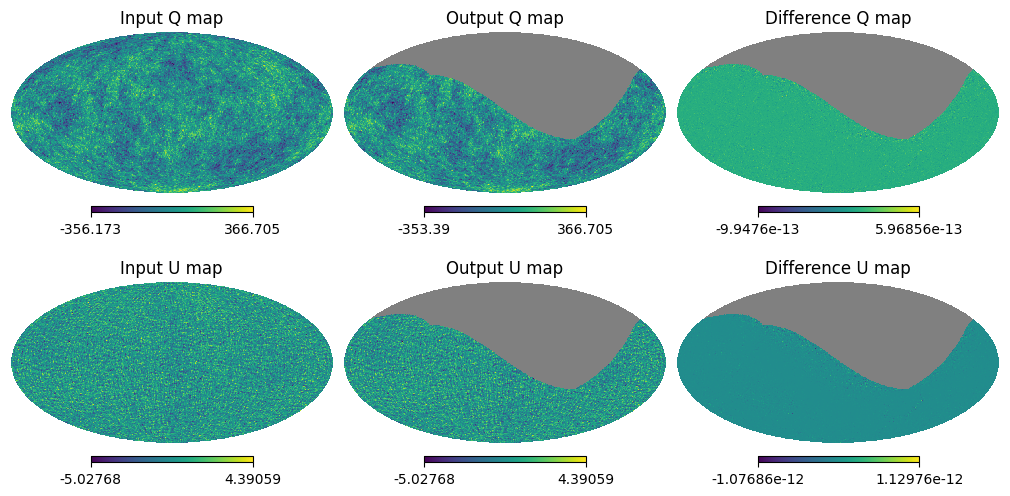

In [15]:
### Plotting and comparing the input and output maps
plt.figure(figsize=(10, 5))

hp.mollview(input_maps[0][channel][0], sub=231, title="Input Q map")
hp.mollview(gls_result.GLS_maps[0], sub=232, title="Output Q map")
hp.mollview(
    input_maps[0][channel][0] - gls_result.GLS_maps[0],
    sub=233,
    title="Difference Q map",
)

hp.mollview(input_maps[0][channel][1], sub=234, title="Input U map")
hp.mollview(gls_result.GLS_maps[1], sub=235, title="Output U map")
hp.mollview(
    input_maps[0][channel][1] - gls_result.GLS_maps[1],
    sub=236,
    title="Difference U map",
)

### Comments on the result

The gray pixels in the output map indicate the bad pixels excluded from the map-making. These are the same pixels reported during the map-making.